# The Distance of Slavery 
## Andrea Hayes
### July 31, 2024

# Introduction 

Slavery is a dark part in the history of America, specifically in the south. The southern states used slave labor to strengthen their economy. They benefited so much that by the early 1860’s they would have been the 4th largest economy in the world had they been a separate nation[2]. This type of impact on their economy made it quite obvious that they were not going to give it up willingly. Like many things in politics the change to abolish slavery took decades and came in many forms. This meant that the men of the south knew that change would be coming long before it actually did. How they approached slavery would depend on where they were located and how the politics changed from decade to decade. By the end of the 1850’s it was clear that the decades long debate was coming to a head. 

New Orleans had a unique slave trade in that slaves were sold all throughout the city. It was common in other cities that slaves were sold only in a single market or known locations. In New Orleans though slaves could be sold about anywhere you could think of. The Historic New Orleans Collection lists the numerous places, “Auction blocks in the sumptuous rotunda of the St. Louis Hotel, private residences, public parks, decks of ships moored along the Mississippi, high-walled slave pens, and commercial complexes such as Banks Arcade all served as sites for the buying and selling of human beings”.[3]  This approach to how slaves were bought and sold made New Orleans a vital market for the slave trade. 
As pressure to abolish slavery mounted from the union it changed how much business the slave trade conducted.   

In their paper that used the same dataset, authors Calomiris and Pritchett found the price of slaves in 1861 had dropped by one third since 1860. They explain that by this time slave owners saw the writing on the wall that they were not going to get compensated after emancipation.[1] The political climate was changing with the looming war over slavery and what rights the states had. They showed that the commodity that was slavery changed as the onset of the war began. 

As we live through historical events it seems obvious or sometimes not so obvious about the decisions we make based on how we think the future will be. We don't always have the foresight for these decisions. Most of the time there are too many factors at play for us to be able to see how it will all play out. The dataset with slavery from 1856 - 1861 made me wonder if men of the time changed their decisions based on the political climate. If they were in the south and assumed the south would succeed then they would see no need to change how they did business. If they were in the north it was becoming tricker to participate in the slave trade and they needed to travel farther. 

 ## Research Questions
  Did the geographic distribution of buyers or sellers of slaves change as the civil war approached?
  
  How far did the average person travel to sell a slave in New Orleans? 


# Methods

 The dataset from CORGIS has the records of 9,599 slaves sold in New Orleans from 1856 - 1861. It has a wide variety of information from the buyer, seller and slave on each sale. It includes the buyers and sellers names and where they are from. For the slaves it includes their gender, age, amount sold for, and other financial information. To get the distance from New Orleans to the various cities I made my own dataset. I exported the seller's origins into Google sheets and used a script to calculate the distances.   

### Cleaning
Since my questions focus on where the buyers and sellers are from and the distance they traveled I focused on the buyer origin and seller origin as well as the year of the transaction. The CORGIS dataset gives not only the year, but the full transaction date. Since I am only interested in the year I converted it to datetime so that I could extract the year. Before doing this I needed to change the day format because some had a '.' instead of the day. I replaced the '.' with NaN values. I was then able to extract just the year from the transaction date.

The buyer and sellers origins were the same format they contained which was a city and state. There were unknown cities and since this information was not necessary I removed it from the dataset. Next I noticed that sometimes a ',' was put after the whitespace instead of before and that 'New Orleans' was sometimes simplified to 'Orleans'. I applied the replace function to account for both of these occurrences. At this point the data was ready to be analyzed and I did so with the group function. I grouped the cities by year and then extracted the top 5 cities. 

To get the distances from New Orleans to the seller's origins I exported the sellers origins into a google sheet. I had a previous script to calculate the driving distances from a personal project. Once I removed the error cells from the csv I merged the distance data with the slavery data. This allowed me to find the average distance traveled by sellers per year.  

# Results




In [237]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Retrieve html code from CORGIS
url = "https://corgis-edu.github.io/corgis/csv/"
response = requests.get(url)
html_content = response.text

#Parse the html and create a list
soup = BeautifulSoup(html_content, 'html.parser')
h3_tags = soup.find_all('h3')

#Make list of all dataset names that CORGIS has
corgis_list = [tag.get_text() for tag in h3_tags]


#Takes in number of dataset and returns a Pandas dataframe
def pdcorgis(dataset_name):

    #Convert to lowercase and add _ to needed datasets
    dataset_name_lower = dataset_name.lower().replace(' ', '_')
    # print(dataset_name_lower)
    
    #Get HTML from CORGIS page
    dataset_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/"
    dataset_response = requests.get(dataset_url)
    dataset_html_content = dataset_response.text

    #Parse the HTML and find links
    dataset_soup = BeautifulSoup(dataset_html_content, 'html.parser')
    links = dataset_soup.find_all('a')

    #Find download link
    download_link = None
    for link in links:
        if link.has_attr('download'):
            download_link = link['href']
            break

    if download_link is None:
        raise ValueError("Download link for {dataset_name} not found")
    
    #Get link to use for csv
    csv_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/{download_link}"
    # print(csv_url)

    #Read the csv file into Pandas
    corgis_dataframe = pd.read_csv(csv_url)

    return corgis_dataframe


In [240]:
#Get the slavery dataset from CORGIS
slavery_data = pdcorgis(corgis_list[47]) 

# print(slavery_data.head()) 
# print(slavery_data)

# Remove unknown values from the buyer and seller city
slavery_data = slavery_data[slavery_data['Buyer.Origin'] != 'Unknown, Unknown'] 
slavery_data = slavery_data[(slavery_data['Seller.Origin'] != 'Unknown, Unknown') & (slavery_data['Seller.Origin'] != 'Unknown, LA')]
# print(slavery_data)

# Replace dots in date with with NaN
slavery_data['Transaction.Date'].replace('.', np.nan, inplace=True)

# Convert the 'Transaction.Date' column to datetime, errors='coerce' will convert invalid dates to NaT
slavery_data['Transaction.Date'] = pd.to_datetime(slavery_data['Transaction.Date'], format='%m/%d/%Y', errors='coerce')

# Retrieve the year from the transaction date
year = slavery_data['Year'] = slavery_data['Transaction.Date'].dt.year
# print(year)

#Normalize the Cities by striping whitespace and replacing , with whitespace, put Orleans and New Orleans together
slavery_data['Buyer.Origin'] = (slavery_data['Buyer.Origin'].str
    .replace(r"^Orleans\,\sLA$", "New Orleans, LA", regex=True)
    .replace(r"(\w+)\s*,\s*(\w{2})", r"\1, \2", regex=True)
)

slavery_data['Seller.Origin'] = (slavery_data['Seller.Origin'].str
    .replace(r"^Orleans\,\sLA$", "New Orleans, LA", regex=True)
    .replace(r"(\w+)\s*,\s*(\w{2})", r"\1, \2", regex=True)
)

# Assure only getting the years 1856 - 1861
years_wanted = [1856, 1857, 1858, 1859, 1860, 1861]
filtered_years = slavery_data[slavery_data['Year'].isin(years_wanted)]
# print("Filtered_years" , filtered_years)

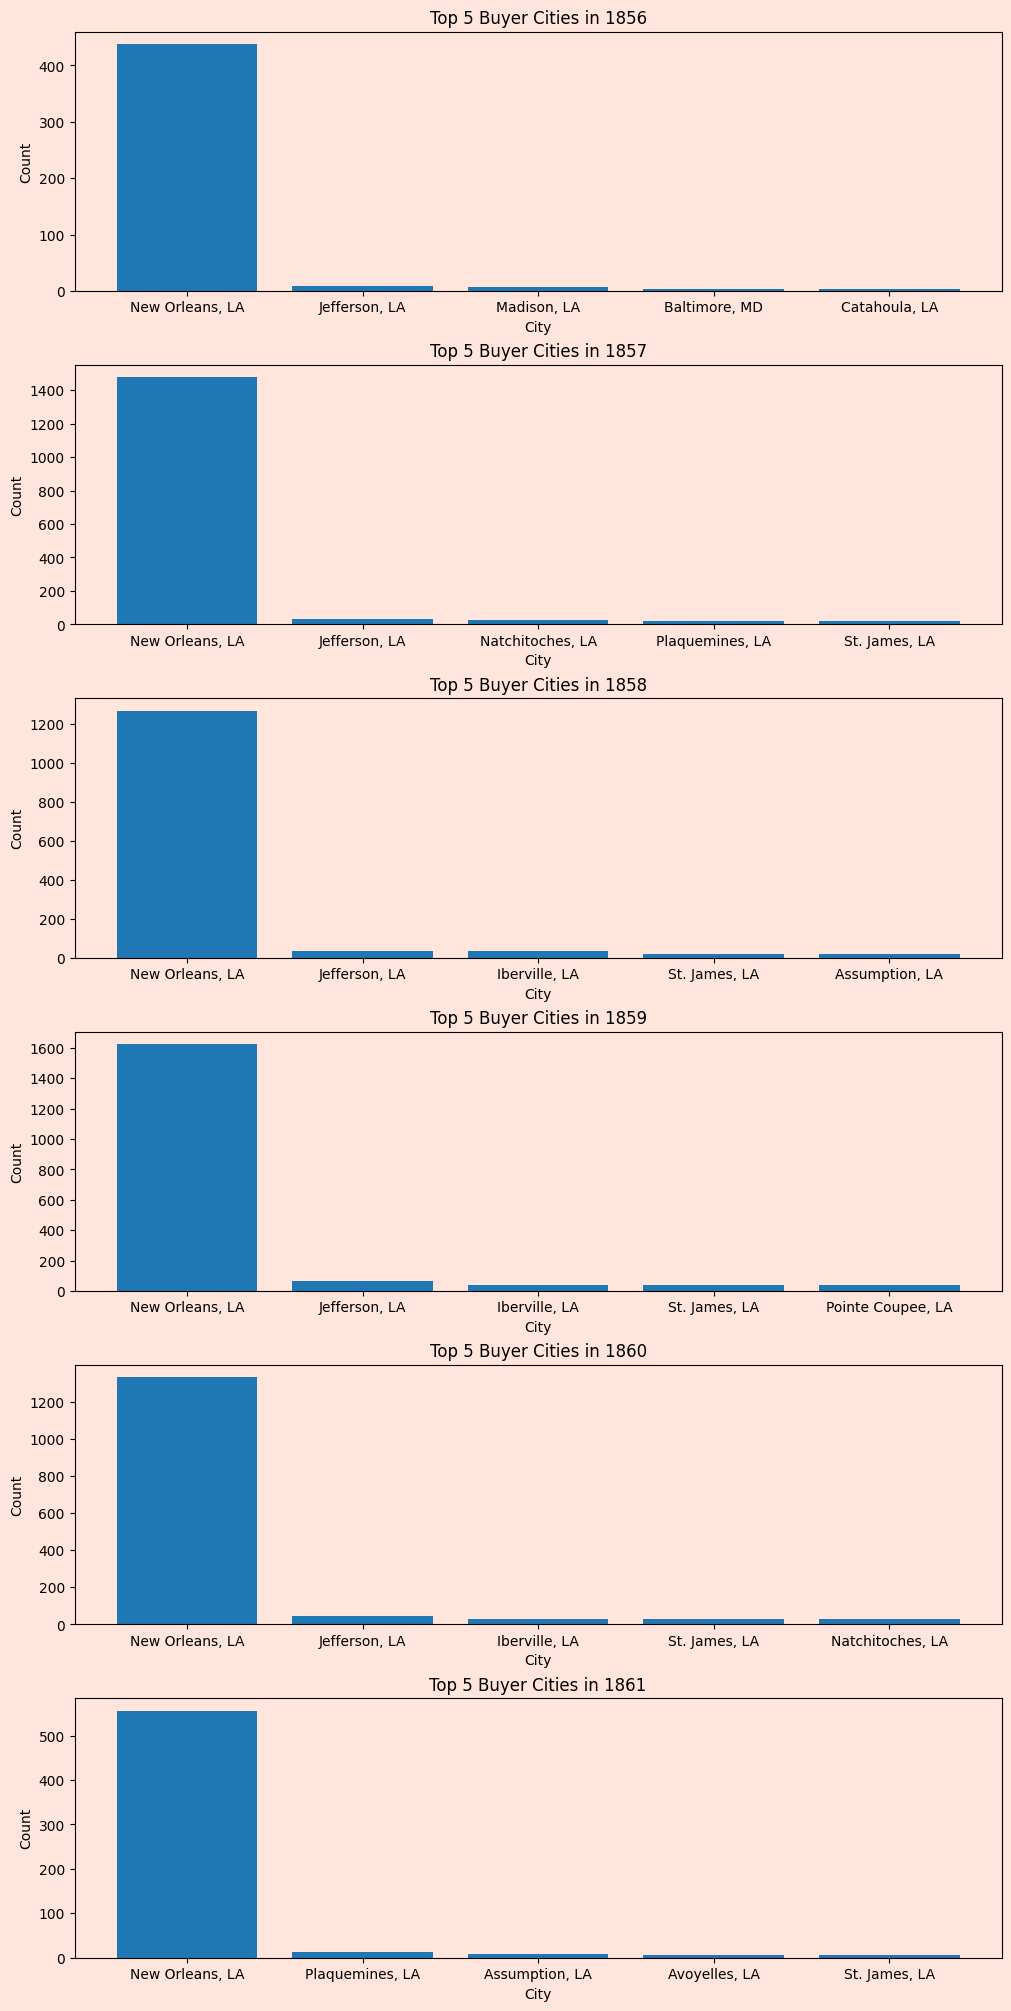

In [248]:
#Top 5 Cities Buyer's were from for 1856 - 1861

# Group by year and get top 5 cities for each year
top_buyer_cities_per_year = filtered_years.groupby(['Year', 'Buyer.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

# Plot
years = filtered_years['Year'].unique()
# print(years)

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)
fig.patch.set_facecolor('#ffe5dc')
for ax in axes:
    ax.set_facecolor('#ffe5dc')

for i, year in enumerate(years):
    top_cities = top_buyer_cities_per_year[top_buyer_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Buyer.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Buyer Cities in {int(year)}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

# Analysis for Buyer Origins
These six bar graphs tell us that the people buying slaves were local. They also didn't go far with the vast majority of slaves staying in New Orleans. Aside from one outlier in 1856 from Baltimore they are all from Louisiana. This tells us that slaves purchased in New Orleans stayed local. These graphs also contain a count for the number of slaves sold each year. 1856 was the lowest year with around 500 total slaves sold. While 1857 -1860 saw between 1,200 and 1,600 slaves sold each year. When looking at the difference between 1860 and 1861 there is a drastic decrease from more than 1,200 in 1860 to just over 500 in 1861. The start of the civil war clearly had and impact on the slave trade.  

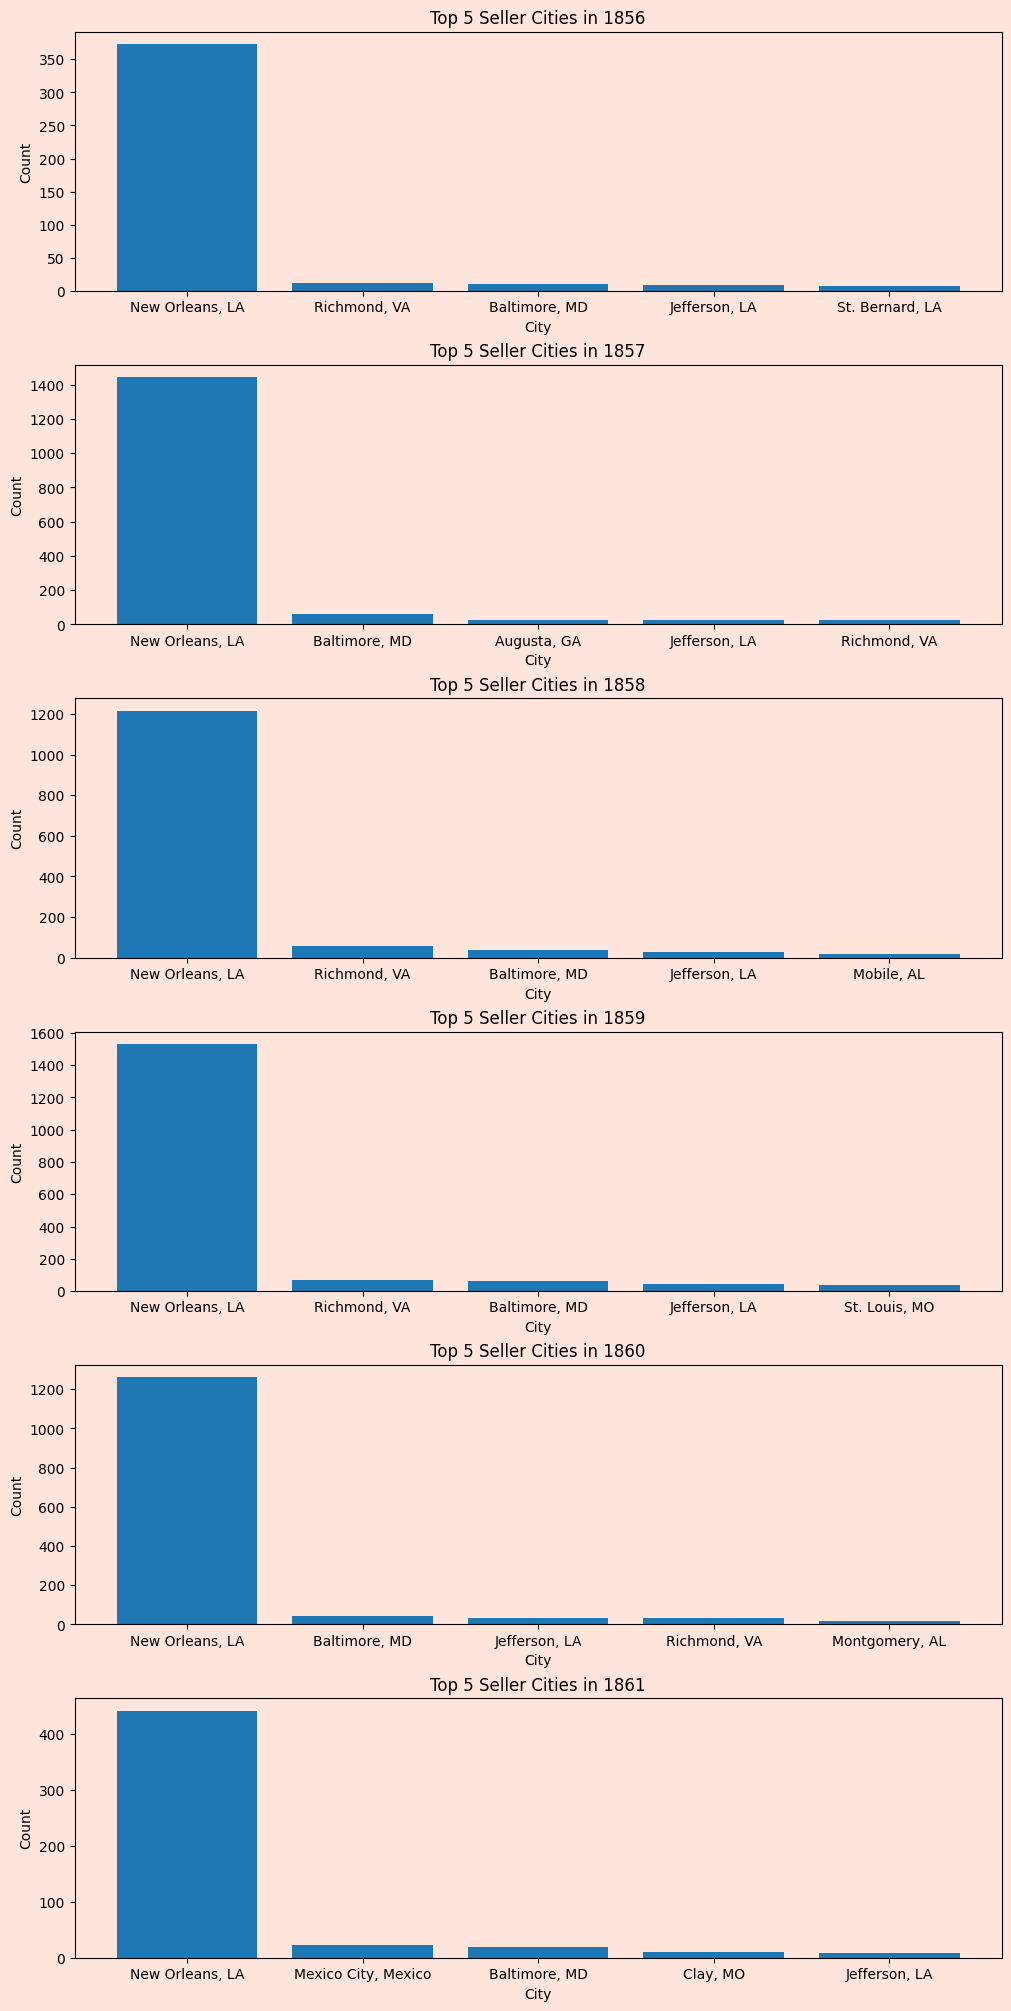

In [250]:
#Top 5 Cities Seller's were from 1856 - 1861 
top_seller_cities_per_year = filtered_years.groupby(['Year', 'Seller.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)

fig.patch.set_facecolor('#ffe5dc')
for ax in axes:
    ax.set_facecolor('#ffe5dc')

for i, year in enumerate(years):
    top_cities = top_seller_cities_per_year[top_seller_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Seller.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Seller Cities in {int(year)}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

# Analysis for Seller Origins

The bar graphs for where the sellers come from gives a much more interesting look at the slave trade. Most of the sellers were still local being from New Orleans. But the next 4 cities for most of the years come from a variety of different places, many quite far away. Cities like Baltimore, MD and Richmond, VA show up frequently even before the civil war ramped up. The buyers were local so slaves were coming from the north to be sold in the south where they stayed. The outlier on these graphs is Mexico City in 1861. Since the information was pulled from the same dataset it makes sense that the number of slaves sold is similar to the buyer origins graphs.  

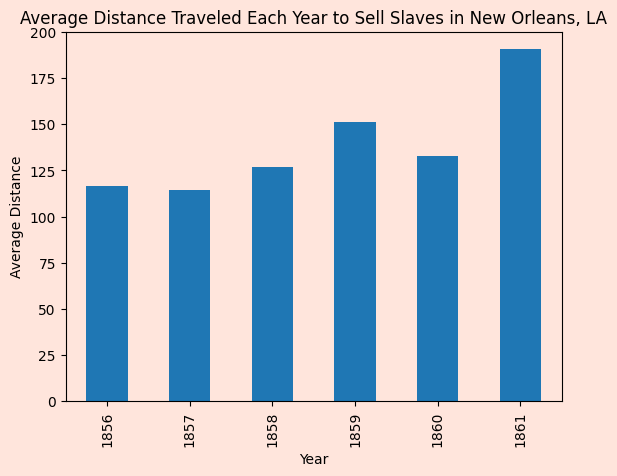

In [254]:
#Distance from New Orleans

#Read in csv and remove Error cells
distance_data = pd.read_csv("Distances_from_New_Orleans.csv" )
distance_data = distance_data[distance_data['Distance'] != "#ERROR!"]
# print(distance_data)

#Merge slavery and distance datasets
slavery_data_with_distances = pd.merge(slavery_data, distance_data, left_on='Seller.Origin', right_on='City', how='left')

#Drop na columns and convert to integers
slavery_data_with_distances = slavery_data_with_distances.dropna(subset=['Distance'])
slavery_data_with_distances['Distance'] = slavery_data_with_distances['Distance'].astype(int)
# print(slavery_data_with_distances.shape[0])

#Get the year
slavery_data_with_distances = slavery_data_with_distances[slavery_data_with_distances['Year'].isin(years)]

# Plot

#Use group by to get the average distance for each year
avg_distance_by_year = (slavery_data_with_distances
    .groupby('Year')
    ['Distance'].mean()
    .reset_index()
)


avg_distance_by_year.plot(kind='bar', x='Year', y='Distance', legend=False)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()
fig.patch.set_facecolor('#ffe5dc')
ax.set_facecolor('#ffe5dc')

# Set x-axis ticks to be integers
ax.set_xticks(range(len(avg_distance_by_year['Year'])))
ax.set_xticklabels(avg_distance_by_year['Year'].astype(int))

plt.xlabel('Year')
plt.ylabel('Average Distance')
plt.title('Average Distance Traveled Each Year to Sell Slaves in New Orleans, LA')

plt.show()




# Analysis of Distance Traveled    

The average distance a slave traveled did not change a vast majority over the years. We know from the previous charts for sellers that the slaves were local or traveled a great distance. The slaves from Baltimore, Richmond, and Mexico traveled over 1,000 miles. There is a spike in 1861 that shows as the war neared people were traveling farther to sell their slaves. They were not selling as many slaves, but those being sold were coming from a greater distance. 

# Discussion
 
The analysis of slave sales in New Orleans during 1861, compared to the five years preceding, reveals notable trends in the origins and distances traveled by sellers. While the majority of slaves were still bought and sold locally within New Orleans, there was a discernible increase in the average distance traveled by sellers from northern states and Mexico. This increase, although not substantial, highlights a shift in the slave trade dynamics as the Civil War approached.

The presence of slaves from Mexico is interesting because it abolished slavery in 1837 and was known to be a refuge for slaves from Texas[4]. This raises questions that maybe people were forcibly returning escaped slaves to the United States. This surprising finding highlights the complexity and far-reaching impact of the slave trade.

The dataset, focused solely on New Orleans, suggests that to gain a more comprehensive understanding, further research including additional Confederate cities would be necessary. The trend of fewer slaves being sold as the war neared, coupled with increased travel distances, indicates a possible strategy by northern slaveholders to maximize profits by transporting slaves to markets where they could fetch higher prices.

Overall, the study highlights the localized nature of the slave trade in New Orleans, the resilience of established trade routes, and the economic pressures influencing the movement and sale of slaves during a tumultuous period in American history.

# References 

1. Calomiris, Charles W., and Jonathan Pritchett. 2016. "Betting on Secession: Quantifying Political Events Surrounding Slavery and the Civil War." American Economic Review, 106 (1): 1–23. DOI: 10.1257/aer.20131483

2. Timmons, Greg. "How Slavery Became the Economic Engine of the South." HISTORY, A&E Television Networks, 2 Apr. 2024, https://www.history.com/news/slavery-profitable-southern-economy. Accessed 27 July 2024.

3. "New Orleans, Slave Market of the South." The Historic New Orleans Collection, accessed July 27, 2024. https://www.hnoc.org/virtual/purchased-lives/new-orleans-slave-market-south.

4. NPR Staff. "A Chapter In U.S. History Often Ignored: The Flight Of Runaway Slaves To Mexico." NPR, 28 Feb. 2021, https://www.npr.org/2021/02/28/971325620/a-chapter-in-u-s-history-often-ignored-the-flight-of-runaway-slaves-to-mexico.

5. https://corgis-edu.github.io/corgis/csv/slavery/ Accessed 25 July 2024